In [1]:
-- Code for Wide Residual Networks http://arxiv.org/abs/1605.07146
-- (c) Sergey Zagoruyko, 2016
require 'xlua'
require 'optim'
require 'image'
require 'cunn'
require 'cudnn'
c = require 'trepl.colorize'
json = require 'cjson'
require'augmentation'
model_utils = require 'model_utils'   ---sjmod
require'provider'
require'nngraph'
require 'csvigo'

-- for memory optimizations and graph generation
local optnet = require 'optnet'
local graphgen = require 'optnet.graphgen'
local iterm = require 'iterm'
require 'iterm.dot'

opt = {
  save = 'logs_stanfordaction40/resnet164-1_baseline',
  batchSize = 64, --128,
  learningRate = 0.1,   ------overwritten
  learningRateDecay = 0,   ------overwritten
  learningRateDecayRatio = 0.2,   ------overwritten
  weightDecay = 0.0005,
  dampening = 0,
  momentum = 0.9,
  epoch_step = "80",   ------overwritten
  max_epoch = 300,   ------overwritten

  model = 'model.t7',

  optimMethod = 'sgd',
  init_value = 10,
  depth = 50,
  shortcutType = 'A',
  nesterov = false,   ------overwritten
  dropout = 0,
  hflip = true,
  randomcrop = 4,
  imageSize = 32,
  randomcrop_type = 'zero',   ------overwritten
  cudnn_fastest = true,
  cudnn_deterministic = false,
  optnet_optimize = true,
  generate_graph = false,
  multiply_input_factor = 1,
  widen_factor = 1,
}
opt = xlua.envparams(opt)

opt.epoch_step = tonumber(opt.epoch_step) or loadstring('return '..opt.epoch_step)()
--print(opt)


==> loading data	


 2
[torch.ByteTensor of size 1]



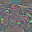

In [2]:
print(c.blue '==>' ..' loading data')
provider = torch.load('/media/sjvision/DATASETDISK/atest/StanfordAction40/t7_files/stanfordaction40_whitened.t7')
--provider = torch.load('./datasets/cifar10_whitened.t7')
print(provider.testData.labels[400])
itorch.image(provider.testData.data[400])

In [3]:
print(c.blue '==>' ..' configuring models')
model = nn.Sequential()
net = torch.load('logs/cifar100_Resnet-pre-act_164_1/' ..opt.model):cuda()

==> configuring models	


In [4]:
do
   ------Main Model----------INITIALIZATION-----------------
   model:add(nn.Copy('torch.FloatTensor','torch.CudaTensor'):cuda())   
   model:add(net) -- adding the network -- sjmod
end

In [5]:
--[[
model_all = {}
table.insert(model_all, model_1_1)

table.insert(model_all, model_1_2)
table.insert(model_all, model_2_2)
table.insert(model_all, model_3_2)

table.insert(model_all, model_1_3)
table.insert(model_all, model_2_3)
table.insert(model_all, model_3_3)

table.insert(model_all, model_4)
local parameters, gradParameters = model_utils.combine_all_parameters(model_all)
--local parameters,gradParameters = model:getParameters()   --sjmod

opt.n_parameters = parameters:numel()
print('Network has ', parameters:numel(), 'parameters')

print(c.blue'==>' ..' setting criterion')
local criterion = nn.CrossEntropyCriterion():cuda()
--]]
function test()
  
    model:evaluate()
    --local confusion = optim.ConfusionMatrix(10)
    
    bs = 1
    nsamples = provider.testData.data:size(1)
    fv_output = torch.zeros(nsamples,256)
    
  for i = 1,nsamples,bs do 
        local pred = model:forward(provider.testData.data:narrow(1,i,bs))
        fv_output[i] = model:get(2):get(8).output:squeeze():float()
        --[[
        val, ind = torch.max(pred,2)
        print(ind)
        print(provider.testData.labels[i])       
        confusion:batchAdd(pred, provider.testData.labels:narrow(1,i,bs))   ---testing fwd   ---sjmod
        confusion:updateValids()
        --]]
  end
    fv_output = fv_output:totable()
    csvigo.save('logs_stanfordaction40/resnet164-1_baseline_zca_100.txt',fv_output)
    
  return 0 --confusion.totalValid * 100
    
end


In [6]:
for epoch=1,1 do
  local test_acc, test_time =test()  ----sjmod
  print(test_acc)
end

<csv>	writing to file: logs_stanfordaction40/resnet164-1_baseline_zca_100.txt	


<csv>	writing done	
0	
